# Create and Train the model

## Download, Imports, and Config

Make sure to run the correct PyTorch install command such as

```conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia```

in your conda environment before running this notebook.

This command can be found from the official PyTorch website: https://pytorch.org/get-started/locally/

Imports

In [1]:
# Custom imports
import sys
sys.path.insert(1, "../libs")
from postgres_data import load_postgresql_data

# General imports
import os
import random
import time
import datetime
import gc

# ML imports
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

Config

In [2]:
SEED = 777
VALIDATION_RATIO = 0.2 # 20% of training data will be used for validation

MODEL_TYPE = "bert-base-multilingual-uncased"
L_RATE = 1e-5
MAX_LEN = 80
NUM_EPOCHS = 3
BATCH_SIZE = 16 # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
NUM_CORES = 0 # os.cpu_count()

torch.manual_seed(SEED)

MODELS_DIR = "./models"
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

# Check for GPU to speed up training
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print("There are %d GPU(s) available." % torch.cuda.device_count())

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not...
else:
    # device = torch.device("cpu")
    raise Exception("No GPU available, please setup GPU with CUDA before running this notebook")

# Note: For TPU
# device = xm.xla_device()

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080


## Loading Data and Preprocessing

Load Data

In [3]:
# create train and test dataframes
train_df_presplit, test_df = load_postgresql_data()

Preprocessing

In [4]:
#train_test_split to create validation set
train_df, val_df = train_test_split(train_df_presplit, random_state=SEED, test_size=VALIDATION_RATIO)
train_df.reset_index(drop=True, inplace=True) # reset indecies, otherwise indecies would be retained from original df
val_df.reset_index(drop=True, inplace=True)
print("Train data size: ", train_df.size)
print("Validation data size: ", val_df.size)

Train data size:  58176
Validation data size:  14544


## Define Model and Training

### Setup Datasets to use BERT's encoding, and DataLoaders for each Dataset

In [5]:
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)
len(tokenizer.vocab)

105879

To encode a sentence with BERT, we are required to:

  -  Add special tokens to the start and end of each sentence.
  -  Pad & truncate all sentences to a single constant length.
  -  Explicitly differentiate real tokens from padding tokens with the "attention mask".


In [6]:
def encode_sentence_pair(sentence1, sentence2):
    """
    Encode a sentence pair using BERT tokenizer and return the encoded array
    """
    encoded_dict = tokenizer.encode_plus(
        sentence1, sentence2,           # Sentences to encode.
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad or truncate.
        padding = "max_length",
        return_attention_mask = True,   # Construct attn. masks.
        return_tensors = "pt",          # Return pytorch tensors.
        truncation = True
    )

    # These are torch tensors
    padded_token_list = encoded_dict["input_ids"][0]
    att_mask = encoded_dict["attention_mask"][0]
    token_type_ids = encoded_dict["token_type_ids"][0]

    return (padded_token_list, att_mask, token_type_ids)

In [7]:
class LabelledDataset(Dataset):

    def __init__(self, df):        
        self.df_data = df


    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence1 = self.df_data.loc[index, "premise"]
        sentence2 = self.df_data.loc[index, "hypothesis"]

        # Encode the sentences
        padded_token_list, att_mask, token_type_ids = encode_sentence_pair(sentence1, sentence2)
        
        # Convert the target to a torch tensor
        target = torch.tensor(self.df_data.loc[index, "label"])

        sample = (padded_token_list, att_mask, token_type_ids, target)        

        return sample


    def __len__(self):
        return len(self.df_data)

In [8]:
class TestDataset(Dataset):

    def __init__(self, df):
        self.df_data = df


    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence1 = self.df_data.loc[index, "premise"]
        sentence2 = self.df_data.loc[index, "hypothesis"]

        # Encode the sentences
        padded_token_list, att_mask, token_type_ids = encode_sentence_pair(sentence1, sentence2)               

        sample = (padded_token_list, att_mask, token_type_ids)

        return sample


    def __len__(self):
        return len(self.df_data)

In [9]:
train_data = LabelledDataset(train_df)
val_data = LabelledDataset(val_df)
test_data = TestDataset(test_df)

train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_CORES,
    pin_memory=True # Speeds up data transfer from CPU to GPU
)

val_dataloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_CORES,
    pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_CORES,
    pin_memory=True
)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

606
152
325


In [10]:
# testing out our dataloader to ensure correct output of 1 batch
train_iter = iter(train_dataloader)
padded_token_list, att_mask, token_type_ids, target = next(train_iter)

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


### Model Definition

In [11]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    num_labels = 3, # The number of output labels--In our case 3
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)
model.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [12]:
# Print information about the model

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.\n".format(len(params)))

print("==== Embedding Layer ====\n")

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer ====\n")

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== Output Layer ====\n")

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

Quick test of the model outputs

In [13]:
batch = next(train_iter)

b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_token_type_ids = batch[2].to(device)
b_labels = batch[3].to(device)

In [14]:
outputs = model(
    b_input_ids, 
    token_type_ids=b_token_type_ids, 
    attention_mask=b_input_mask,
    labels=b_labels
)

In [15]:
outputs

SequenceClassifierOutput(loss=tensor(1.1789, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.9198,  0.4752, -0.1098],
        [ 1.1001,  0.6670, -0.2070],
        [ 0.2564,  0.1741, -0.0255],
        [ 1.2721,  0.5832, -0.1534],
        [-0.3171, -0.0272,  0.0790],
        [ 0.5413,  0.5114, -0.1306],
        [ 0.4053,  0.2602, -0.1467],
        [ 0.3401,  0.2550, -0.1992],
        [ 0.4960,  0.3067, -0.1486],
        [ 0.7442,  0.5038, -0.4522],
        [ 0.6268,  0.3220, -0.0781],
        [ 1.0172,  0.5420, -0.2381],
        [ 1.0084,  0.3417, -0.2037],
        [ 1.0759,  0.5913,  0.0179],
        [ 0.5961,  0.4875, -0.0893],
        [ 1.0723,  0.3235, -0.2735]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [16]:
# Get the predictions for each training example in the batch.
preds = outputs[1].detach().cpu().numpy()

y_true = b_labels.detach().cpu().numpy()
y_pred = np.argmax(preds, axis=1)

y_pred

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [17]:
# This is the accuracy without any fine tuning based on the first batch of the training set.
val_acc = accuracy_score(y_true, y_pred)
val_acc

0.375

Optimizer and Scheduler

In [18]:
optimizer = AdamW(model.parameters(), lr=L_RATE, eps = 1e-8) # eps is added to avoid nan (term that is added to the denominator)

In [19]:
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * NUM_EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = total_steps
)

### Training

Initialization

In [20]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Store the average loss and validation accuracy after each epoch so we can plot them.
loss_values = []
accuracy_values = []
val_loss_values = []
val_accuracy_values = []

Helper Functions

In [21]:
def flat_accuracy(preds, labels):
    '''
    Function to calculate the accuracy of our predictions vs labels
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training loop:

 *   Unpack our data inputs and labels
 *   Load data onto the GPU for acceleration
 *   Clear out the gradients calculated in the previous pass.
     *   In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
 *   Forward pass (feed input data through the network)
 *   Backward pass (backpropagation)
 *   Tell the network to update parameters with optimizer.step()
 *   Track variables for monitoring progress

 Evalution loop:

 *   Unpack our data inputs and labels
 *   Load data onto the GPU for acceleration
 *   Forward pass (feed input data through the network)
 *   Compute loss on our validation data and track variables for monitoring progress

In [23]:
# Disable warning
import transformers
transformers.logging.set_verbosity_error()

# import logging
# logging.disable(logging.WARNING)

In [24]:
%%time

for epoch in range(0, NUM_EPOCHS):

    # ========================================
    #               Training
    # ========================================
          
    print("")
    print("======== Epoch {:} / {:} ========".format(epoch + 1, NUM_EPOCHS))
    print("Training...")

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss, total_accuracy = 0, 0

    # Put the model into training mode.
    model.train()

    # torch.backends.cudnn.benchmark = True

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
            
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print("  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.    Loss: {:0.2f}.    Accuracy: {:0.2f}".format(
                step, 
                len(train_dataloader), 
                elapsed, 
                sum(loss_values[-40:])/40, 
                sum(accuracy_values[-40:])/40)
            )

        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        # Clear out the gradients (by default they accumulate)
        model.zero_grad()

        # Perform a forward pass.
        outputs = model(
            b_input_ids,
            token_type_ids=b_token_type_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs[0]
        logits = outputs[1]

        # Move to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        # Calculate accuracy
        batch_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the training loss and accuracy over all of the batches so we can get the average at the end
        total_loss += loss.item() 
        total_accuracy += batch_accuracy

        # Store the loss and accuracy value for plotting the learning curve.
        loss_values.append(loss.item())
        accuracy_values.append(batch_accuracy)

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients".
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Take a step and update parameters based on the computed gradient.
        optimizer.step()

        # Scheduler updates the learning rate over time.
        scheduler.step()

    # Finished training this epoch.
    # Calculate average loss over all of the batches.
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    print("  Final training loss: {0:.2f}".format(loss_values[-1]))
    print("  Final training accuracy: {0:.2f}".format(accuracy_values[-1]))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_loss, total_eval_accuracy = 0, 0
    num_eval_steps = 0

    # For each batch of validation data...
    for batch in val_dataloader:

        # Unpack batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        # Tell pytorch not to bother with constructing the compute graph during evaluation
        with torch.no_grad():
            outputs = model( # Logits are the model outputs prior to applying an activation function such as softmax.
                b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs[0]
        logits = outputs[1]

        # Move to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        # Calculate the accuracy for this batch of test sentences.
        batch_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumlate loss and accuracy.
        total_eval_loss += loss.item()
        total_eval_accuracy += batch_eval_accuracy

        num_eval_steps += 1

    # Calculate the average loss and accuracy over all batches, and store for plotting.
    eval_loss = total_eval_loss / num_eval_steps
    eval_accuracy = total_eval_accuracy / num_eval_steps

    # Store the loss and accuracy value for plotting the learning curve. We only need to do this once per epoch in validation.
    val_loss_values.append(eval_loss)
    val_accuracy_values.append(eval_accuracy)

    # Print accuracy over all batches
    print("  Loss: {0:.2f}".format(eval_loss))
    print("  Accuracy: {0:.2f}".format(eval_accuracy))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Save the model checkpoint    
    torch.save(model.state_dict(), '{}/model_checkpoint_{:}_{}ep_{:0.0f}acc.pt'.format(MODELS_DIR, time.strftime("%Y%m%d-%H%M"), epoch+1, eval_accuracy*100))

    # Use the garbage collector to save memory.
    gc.collect()

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...


  Batch    40  of    606.    Elapsed: 0:00:07.    Loss: 1.11.    Accuracy: 0.37
  Batch    80  of    606.    Elapsed: 0:00:13.    Loss: 1.08.    Accuracy: 0.40
  Batch   120  of    606.    Elapsed: 0:00:20.    Loss: 1.04.    Accuracy: 0.47
  Batch   160  of    606.    Elapsed: 0:00:26.    Loss: 0.98.    Accuracy: 0.51
  Batch   200  of    606.    Elapsed: 0:00:32.    Loss: 0.97.    Accuracy: 0.52
  Batch   240  of    606.    Elapsed: 0:00:39.    Loss: 0.99.    Accuracy: 0.52
  Batch   280  of    606.    Elapsed: 0:00:45.    Loss: 0.95.    Accuracy: 0.55
  Batch   320  of    606.    Elapsed: 0:00:52.    Loss: 0.96.    Accuracy: 0.57
  Batch   360  of    606.    Elapsed: 0:00:59.    Loss: 0.97.    Accuracy: 0.51
  Batch   400  of    606.    Elapsed: 0:01:05.    Loss: 0.92.    Accuracy: 0.54
  Batch   440  of    606.    Elapsed: 0:01:12.    Loss: 0.93.    Accuracy: 0.57
  Batch   480  of    606.    Elapsed: 0:01:18.    Loss: 0.95.    Accuracy: 0.55
  Batch   520  of    606.    Elapsed: 0:

## Visualize and Evaluting the Model

In [25]:
# Smooth the graph a little by averaging the values in groups of k size
k = 25
smooth_loss_values = [sum(loss_values[(i*k):(i*k)+k]) / float(k) for i in range(0, int(len(loss_values) / k))]
print(smooth_loss_values)
smooth_loss_values_x = [(i * k) + int(k / 2) for i in range(0, (int(len(loss_values) / k)))]
print(smooth_loss_values_x)

[1.1163535284996033, 1.09445378780365, 1.0857003593444825, 1.0589845275878906, 1.0242486691474915, 0.967253007888794, 0.9605813026428223, 0.9780886745452881, 0.9700891709327698, 1.0013802766799926, 0.940884222984314, 0.9402871131896973, 0.970627019405365, 0.9778765654563903, 0.9562707114219665, 0.9008043670654297, 0.9396983337402344, 0.9614556527137756, 0.9202276182174682, 0.897247142791748, 0.8849274945259095, 0.9625440502166748, 0.909898760318756, 0.888244354724884, 0.8460721635818481, 0.7694114339351654, 0.7287603235244751, 0.7304187965393066, 0.8422008633613587, 0.8137454271316529, 0.7403089320659637, 0.7612618160247803, 0.7945981454849244, 0.7837717819213867, 0.7871279227733612, 0.7833138251304627, 0.7483844566345215, 0.7598099946975708, 0.7725727975368499, 0.7679017543792724, 0.7583208441734314, 0.7208778202533722, 0.7559217166900635, 0.7319130253791809, 0.7172589814662933, 0.8183003449440003, 0.7946350240707397, 0.7656403970718384, 0.6802670776844024, 0.6567850005626679, 0.65887

In [26]:
# Setup Validation Loss
val_loss_values_x = [i * int(len(loss_values) / NUM_EPOCHS) for i in range(1, NUM_EPOCHS + 1)]
print(val_loss_values_x)
print(val_loss_values)

[606, 1212, 1818]
[0.8708176895191795, 0.8379430266979494, 0.8678202431060766]


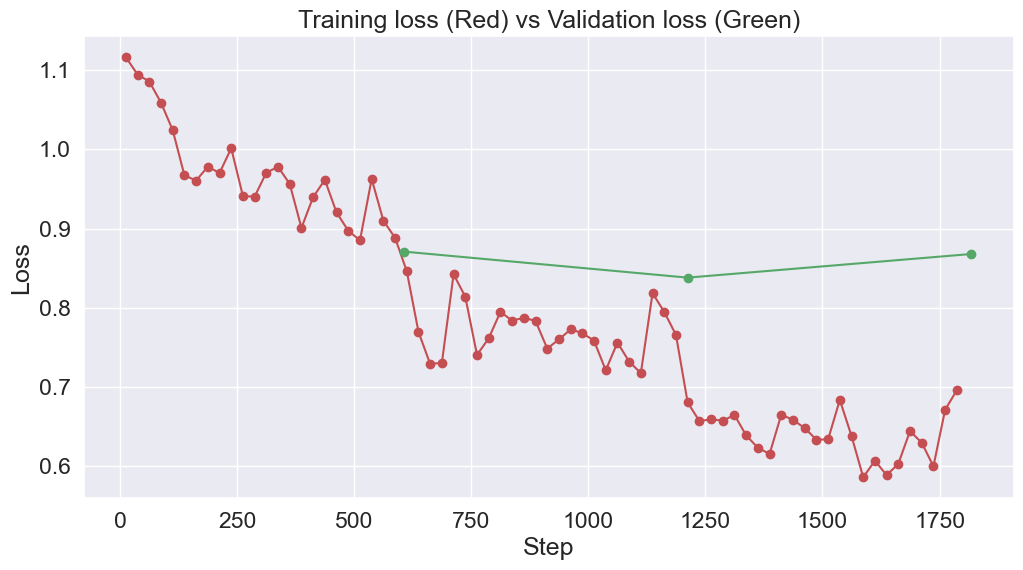

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
# plt.plot(loss_values, 'b-o')
plt.plot(smooth_loss_values_x, smooth_loss_values, 'r-o')
plt.plot(val_loss_values_x, val_loss_values, 'g-o')

# Label the plot.
plt.title("Training loss (Red) vs Validation loss (Green)")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.show()

## Make predictions